In [1]:
# !pip install ipynb --upgrade
# !pip install import-ipynb


In [2]:
import numpy as np
import matplotlib.colors as cl
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from ipynb.fs.full.LK_Multi_Channel import *
import math

UNKNOWN_FLOW_THRESH = 1e7
SMALLFLOW = 0.0
LARGEFLOW = 1e8

< cv2.VideoCapture 0000020C6640FF30>
No frames grabbed!


In [3]:
"""
=============
Flow Section
=============
"""
def show_flow(filename):
    """
    visualize optical flow map using matplotlib
    :param filename: optical flow file
    :return: None
    """
    flow = read_flo_file(filename)
    img = flow_to_image(flow)
    plt.imshow(img)
    plt.show()

In [4]:
def save_flow_image(flow, image_file):
    """
    save flow visualization into image file
    :param flow: optical flow data
    :param flow_fil
    :return: None
    """
    flow_img = flow_to_image(flow)
    img_out = Image.fromarray(flow_img)
    img_out.save(image_file)

In [5]:
def flowfile_to_imagefile(flow_file, image_file):
    """
    convert flowfile into image file
    :param flow: optical flow data
    :param flow_fil
    :return: None
    """
    flow = read_flow(flow_file)
    save_flow_image(flow, image_file)

In [6]:
def read_flo_file(filename, verbose=False):
    """
    Read from .flo optical flow file (Middlebury format)
    :param flow_file: name of the flow file
    :return: optical flow data in matrix
    adapted from https://github.com/liruoteng/OpticalFlowToolkit/
    """
    f = open(filename, 'rb')
    magic = np.fromfile(f, np.float32, count=1)
    data2d = None

    if 202021.25 != magic:
        raise TypeError('Magic number incorrect. Invalid .flo file')
    else:
        w = np.fromfile(f, np.int32, count=1)
        h = np.fromfile(f, np.int32, count=1)
        if verbose:
            print("Reading %d x %d flow file in .flo format" % (h, w))
        data2d = np.fromfile(f, np.float32, count=int(2 * w * h))
        # reshape data into 3D array (columns, rows, channels)
        data2d = np.resize(data2d, (h[0], w[0], 2))
    f.close()
    return data2d

In [7]:
def flow_error(tu, tv, u, v):
    """
    Calculate average end point error
    :param tu: ground-truth horizontal flow map
    :param tv: ground-truth vertical flow map
    :param u:  estimated horizontal flow map
    :param v:  estimated vertical flow map
    :return: End point error of the estimated flow
    """
    smallflow = 0.0
    '''
    stu = tu[bord+1:end-bord,bord+1:end-bord]
    stv = tv[bord+1:end-bord,bord+1:end-bord]
    su = u[bord+1:end-bord,bord+1:end-bord]
    sv = v[bord+1:end-bord,bord+1:end-bord]
    '''
    stu = tu[:]
    stv = tv[:]
    su = u[:]
    sv = v[:]

    idxUnknow = (abs(stu) > UNKNOWN_FLOW_THRESH) | (abs(stv) > UNKNOWN_FLOW_THRESH)
    stu[idxUnknow] = 0
    stv[idxUnknow] = 0
    su[idxUnknow] = 0
    sv[idxUnknow] = 0

    ind2 = [(np.absolute(stu) > smallflow) | (np.absolute(stv) > smallflow)]
    index_su = su[tuple(ind2)]
    index_sv = sv[tuple(ind2)]
    an = 1.0 / np.sqrt(index_su ** 2 + index_sv ** 2 + 1)
    un = index_su * an
    vn = index_sv * an

    index_stu = stu[tuple(ind2)]
    index_stv = stv[tuple(ind2)]
    tn = 1.0 / np.sqrt(index_stu ** 2 + index_stv ** 2 + 1)
    tun = index_stu * tn
    tvn = index_stv * tn

    '''
    angle = un * tun + vn * tvn + (an * tn)
    index = [angle == 1.0]
    angle[index] = 0.999
    ang = np.arccos(angle)
    mang = np.mean(ang)
    mang = mang * 180 / np.pi
    '''
    

    epe = np.sqrt((stu - su) ** 2 + (stv - sv) ** 2)
    epe = epe[tuple(ind2)]
    sdEpe = round(np.std(epe),2)
    mepe = round(np.mean(epe),2)
    return mepe,sdEpe

# jf was here

In [8]:
def calc_MEPE_directory(folder_name):
    flo_in_path = 'ground_truth_flow/'+folder_name+'/flow10.flo'
    #Read flo file
    flow = read_flo_file(flo_in_path)
    #Extract the true u
    tu = flow[:, :, 0]
    #Extract the true v
    tv = flow[:, :, 1]

    # print(f"The true value of u is: \n{tu}")
    # print(f"The shape of u is: \n{tu.shape}")

    prevImg = cv2.imread('dataset/other-data-color/'+folder_name+'/frame10.png')
    NextImg = cv2.imread('dataset/other-data-color/'+folder_name+'/frame11.png')
    
    #calcualte u and v
    u, v, arrow = calcOpticalFlowLK_Multi_Channel(prevImg,NextImg)
    
    #calulate Average End Point Error
    mepe,sdEpe = flow_error(tu, tv, u, v)
    # print("The Average End Point Error for "+folder_name+ " is: " + str(mepe)+" and the standard deviation is: "+str(sdEpe))
    #print("The Average Angular Error is: " + str(mang))

    return u, v

In [16]:
import sys
from turtle import shape
fodler = "Venus"
np.set_printoptions(threshold=sys.maxsize)
u_x, v_y = calc_MEPE_directory(fodler)
np.set_printoptions(threshold = False)

# np_arr = np.asarray(calc_MEPE_directory)

# ups_vect = cv2.resize(np_arr, None, fx= 2, fy= 2, interpolation= cv2.INTER_CUBIC)


In [10]:
v_y.shape

(380, 420)

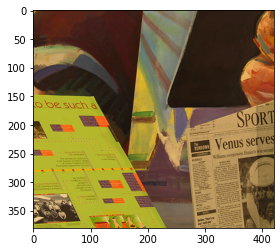

In [11]:
imga = cv2.imread('dataset/other-data-color/'+'Venus'+'/frame10.png')
imga = cv2.cvtColor(imga, cv2.COLOR_BGR2RGB)
plt.imshow(imga)

In [29]:
imga[:,:,0].shape

x_grid = np.arange(imga[:,:,0].shape[0])
y_grid = np.arange(imga[:,:,0].shape[1])

xg, yg = np.meshgrid(x_grid, y_grid)
# f = np.meshgrid(u_x, v_y)

TypeError: Dimensions of C (380, 420) are incompatible with X (380) and/or Y (420); see help(pcolormesh)

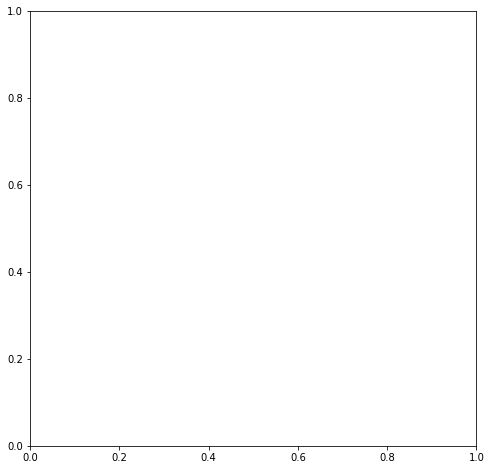

In [31]:
plt.figure(figsize=(8,8))
plt.pcolormesh(xg, yg, ( v_y ))
plt.imshow()

In [14]:
# Both horizontal and vertical 
imgb = cv2.imread('dataset/other-data-color/'+'Venus'+'/frame10.png')
imgb = cv2.cvtColor(imgb, cv2.COLOR_BGR2RGB)

imgc = cv2.remap(imgb,(u_x), v_y, cv2.INTER_LINEAR)
plt.imshow(imgc)

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\imgwarp.cpp:1815: error: (-215:Assertion failed) ((map1.type() == CV_32FC2 || map1.type() == CV_16SC2) && map2.empty()) || (map1.type() == CV_32FC1 && map2.type() == CV_32FC1) in function 'cv::remap'


uint8
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


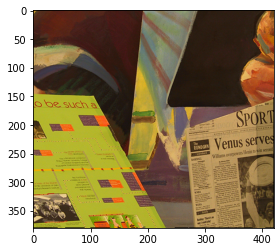

In [18]:
# Both horizontal and vertical 
imgb = cv2.imread('dataset/other-data-color/'+'Venus'+'/frame10.png')
imgb = cv2.cvtColor(imgb, cv2.COLOR_BGR2RGB)
# plt.imshow(imga)

img_r = imgb[:,:,0]
img_g = imgb[:,:,1]
img_b = imgb[:,:,2]
# print(img_r.shape)
rows, cols = img_r.shape
print(imgb.dtype)
img_output_r = np.zeros((imgb.shape[0], imgb.shape[1]), dtype=imgb.dtype)
img_output_g = np.zeros((imgb.shape[0], imgb.shape[1]), dtype=imgb.dtype)
img_output_b = np.zeros((imgb.shape[0], imgb.shape[1]), dtype=imgb.dtype)
print(img_output_r)

for i in range(rows):
    for j in range(cols):
        offset_x = int(math.floor(u_x[i][j])) #int(20.0 * math.sin(2 * 3.14 * i / 150))
        offset_y = int(math.floor(v_y[i][j])) # int(20.0 * math.cos(2 * 3.14 * j / 150))
        if i-offset_y < rows and j-offset_x < cols:
            img_output_r[i,j] = img_r[(i-offset_y)%rows,(j-offset_x)%cols]
            img_output_g[i,j] = img_g[(i-offset_y)%rows,(j-offset_x)%cols]
            img_output_b[i,j] = img_b[(i-offset_y)%rows,(j-offset_x)%cols]

        else:
            img_output_r[i,j] = 0
            img_output_g[i,j] = 0
            img_output_b[i,j] = 0

img_output = np.dstack((img_output_r, img_output_g, img_output_b))
# print(img_output_r.shape)
# img_output = cv2.cvtColor(img_output, cv2.COLOR_GRAY2BGR)
plt.imshow(img_output)


In [ ]:
imga = cv2.imread('dataset/other-data-color/'+'Venus'+'/frame11.png')
imga = cv2.cvtColor(imga, cv2.COLOR_BGR2RGB)
plt.imshow(imga)

# jf was not here

In [ ]:
def calc_MEPE_all():
    folders = ["Dimetrodon","Grove2","Grove3","Hydrangea","RubberWhale","Urban2","Urban3","Venus"]
    for folder in folders:
        calc_MEPE_directory(folder)
        #print(folder +": Succesfully calcualted optical flow")


In [ ]:
calc_MEPE_all()

In [ ]:
##### Angular Error ######

In [ ]:
import numpy as np

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in degrees between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return math.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

In [ ]:
v1 = (8,6)
v2 = (7,9)
angle_between(v1,v2)

In [ ]:
def angle_flow_error(tu, tv, u, v):
    """
    Calculate average end point error
    :param tu: ground-truth horizontal flow map
    :param tv: ground-truth vertical flow map
    :param u:  estimated horizontal flow map
    :param v:  estimated vertical flow map
    :return: End point error of the estimated flow
    """
    smallflow = 0.0
    '''
    stu = tu[bord+1:end-bord,bord+1:end-bord]
    stv = tv[bord+1:end-bord,bord+1:end-bord]
    su = u[bord+1:end-bord,bord+1:end-bord]
    sv = v[bord+1:end-bord,bord+1:end-bord]
    '''
    stu = tu[:]
    stv = tv[:]
    su = u[:]
    sv = v[:]

    idxUnknow = (abs(stu) > UNKNOWN_FLOW_THRESH) | (abs(stv) > UNKNOWN_FLOW_THRESH)
    stu[idxUnknow] = 0
    stv[idxUnknow] = 0
    su[idxUnknow] = 0
    sv[idxUnknow] = 0

    ind2 = [(np.absolute(stu) > smallflow) | (np.absolute(stv) > smallflow)]
    index_su = su[tuple(ind2)]
    index_sv = sv[tuple(ind2)]
    an = 1.0 / np.sqrt(index_su ** 2 + index_sv ** 2 + 1)
    un = index_su * an
    vn = index_sv * an

    index_stu = stu[tuple(ind2)]
    index_stv = stv[tuple(ind2)]
    tn = 1.0 / np.sqrt(index_stu ** 2 + index_stv ** 2 + 1)
    tun = index_stu * tn
    tvn = index_stv * tn

    
    angle = un * tun + vn * tvn + (an * tn)
    #index = [angle == 1.0]
    #print(index)
    #angle[index] = 0.999
    #angle = np.arccos(angle)
    mang = np.mean(angle)
    #mang = mang * 180 / np.pi
        
    sdAngular = round(np.std(angle),2)
    AAE = round(mang,2)

    
    DifferenceAngles = []
    
    '''
    
    for i in range(u.shape[0]):
        for j in range(u.shape[1]):
            vect1 = stu[i,j] + stv[i,j]
            vect2 = su[i,j] + sv[i,j]
            angleBet = angle_between(vect1,vect2)
            DifferenceAngles.append(angleBet)
            
    sdAngular = round(np.std(DifferenceAngles),2)
    AAE = round(np.mean(DifferenceAngles),2)
    
    '''
    
    
    return AAE,sdAngular

In [ ]:
def calc_AAE_directory(folder_name):
    flo_in_path = 'ground_truth_flow/'+folder_name+'/flow10.flo'
    #Read flo file
    flow = read_flo_file(flo_in_path)
    #Extract the true u
    tu = flow[:, :, 0]
    #Extract the true v
    tv = flow[:, :, 1]

    prevImg = cv2.imread('dataset/other-data-color/'+folder_name+'/frame10.png')
    NextImg = cv2.imread('dataset/other-data-color/'+folder_name+'/frame11.png')
    
    #calcualte u and v
    u, v, arrow = calcOpticalFlowLK_Multi_Channel(prevImg,NextImg)
    
    #calulate Average Angular error
    mang,sdAngular = angle_flow_error(tu, tv, u, v)
    print("The Average Angular error for "+folder_name+ " is: " + str(mang)+" and the standard deviation is: "+str(sdAngular))
    #print("The Average Angular Error is: " + str(mang))

In [ ]:
def calc_AAE_all():
    folders = ["Dimetrodon","Grove2","Grove3","Hydrangea","RubberWhale","Urban2","Urban3","Venus"]
    for folder in folders:
        calc_AAE_directory(folder)
        #print(folder +": Succesfully calcualted optical flow")

In [ ]:
calc_AAE_all()

In [ ]:
#Tools: https://github.com/liruoteng/OpticalFlowToolkit/blob/master/lib/flowlib.py

In [ ]:
##### EXTRA's ########

In [ ]:
def make_color_wheel():
    """
    Generate color wheel according Middlebury color code
    :return: Color wheel
    """
    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros([ncols, 3])

    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.transpose(np.floor(255*np.arange(0, RY) / RY))
    col += RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.transpose(np.floor(255*np.arange(0, YG) / YG))
    colorwheel[col:col+YG, 1] = 255
    col += YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.transpose(np.floor(255*np.arange(0, GC) / GC))
    col += GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.transpose(np.floor(255*np.arange(0, CB) / CB))
    colorwheel[col:col+CB, 2] = 255
    col += CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.transpose(np.floor(255*np.arange(0, BM) / BM))
    col += + BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.transpose(np.floor(255 * np.arange(0, MR) / MR))
    colorwheel[col:col+MR, 0] = 255

    return colorwheel

In [ ]:

def flow_to_image(flow):
    """
    Convert flow into middlebury color code image
    :param flow: optical flow map
    :return: optical flow image in middlebury color
    """
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999.
    maxv = -999.
    minu = 999.
    minv = 999.

    idxUnknow = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknow] = 0
    v[idxUnknow] = 0

    maxu = max(maxu, np.max(u))
    minu = min(minu, np.min(u))

    maxv = max(maxv, np.max(v))
    minv = min(minv, np.min(v))

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(-1, np.max(rad))

    u = u/(maxrad + np.finfo(float).eps)
    v = v/(maxrad + np.finfo(float).eps)

    img = compute_color(u, v)

    idx = np.repeat(idxUnknow[:, :, np.newaxis], 3, axis=2)
    img[idx] = 0

    return np.uint8(img)

In [ ]:

def scale_image(image, new_range):
    """
    Linearly scale the image into desired range
    :param image: input image
    :param new_range: the new range to be aligned
    :return: image normalized in new range
    """
    min_val = np.min(image).astype(np.float32)
    max_val = np.max(image).astype(np.float32)
    min_val_new = np.array(min(new_range), dtype=np.float32)
    max_val_new = np.array(max(new_range), dtype=np.float32)
    scaled_image = (image - min_val) / (max_val - min_val) * (max_val_new - min_val_new) + min_val_new
    return scaled_image.astype(np.uint8)


def compute_color(u, v):
    """
    compute optical flow color map
    :param u: optical flow horizontal map
    :param v: optical flow vertical map
    :return: optical flow in color code
    """
    [h, w] = u.shape
    img = np.zeros([h, w, 3])
    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = make_color_wheel()
    ncols = np.size(colorwheel, 0)

    rad = np.sqrt(u**2+v**2)

    a = np.arctan2(-v, -u) / np.pi

    fk = (a+1) / 2 * (ncols - 1) + 1

    k0 = np.floor(fk).astype(int)

    k1 = k0 + 1
    k1[k1 == ncols+1] = 1
    f = fk - k0

    for i in range(0, np.size(colorwheel,1)):
        tmp = colorwheel[:, i]
        col0 = tmp[k0-1] / 255
        col1 = tmp[k1-1] / 255
        col = (1-f) * col0 + f * col1

        idx = rad <= 1
        col[idx] = 1-rad[idx]*(1-col[idx])
        notidx = np.logical_not(idx)

        col[notidx] *= 0.75
        img[:, :, i] = np.uint8(np.floor(255 * col*(1-nanIdx)))

    return img



In [ ]:

def visualize_flow(flow, mode='Y'):
    """
    this function visualize the input flow
    :param flow: input flow in array
    :param mode: choose which color mode to visualize the flow (Y: Ccbcr, RGB: RGB color)
    :return: None
    """
    if mode == 'Y':
        # Ccbcr color wheel
        img = flow_to_image(flow)
        plt.imshow(img)
        plt.show()
    elif mode == 'RGB':
        (h, w) = flow.shape[0:2]
        du = flow[:, :, 0]
        dv = flow[:, :, 1]
        valid = flow[:, :, 2]
        max_flow = max(np.max(du), np.max(dv))
        img = np.zeros((h, w, 3), dtype=np.float64)
        # angle layer
        img[:, :, 0] = np.arctan2(dv, du) / (2 * np.pi)
        # magnitude layer, normalized to 1
        img[:, :, 1] = np.sqrt(du * du + dv * dv) * 8 / max_flow
        # phase layer
        img[:, :, 2] = 8 - img[:, :, 1]
        # clip to [0,1]
        small_idx = img[:, :, 0:3] < 0
        large_idx = img[:, :, 0:3] > 1
        img[small_idx] = 0
        img[large_idx] = 1
        # convert to rgb
        img = cl.hsv_to_rgb(img)
        # remove invalid point
        img[:, :, 0] = img[:, :, 0] * valid
        img[:, :, 1] = img[:, :, 1] * valid
        img[:, :, 2] = img[:, :, 2] * valid
        # show
        plt.imshow(img)
        plt.show()

    return None

In [ ]:
visualize_flow(flow)

In [ ]:
colorwheel = make_color_wheel()
cv2.imshow("wheel",colorwheel)